In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from deepseries.models import BasicSeq2Seq
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from deepseries.optim import ReduceCosineAnnealingLR
from torch.optim import Adam
from torch import nn
import matplotlib as mpl

Text(0.5, 1.0, ' log sin curve with noisy')

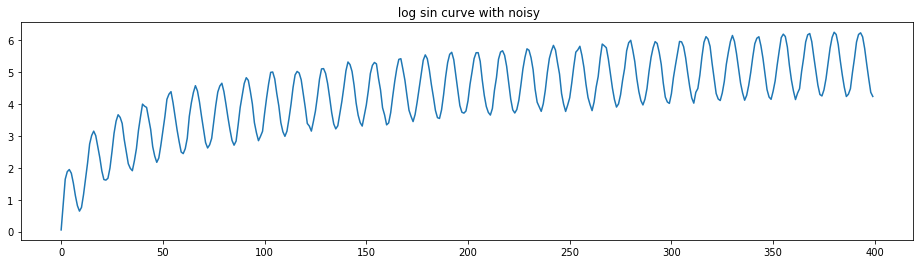

In [55]:
x = np.arange(0, 200, 0.5)
log_sin = np.sin(x) + np.log1p(x) + np.random.normal(0, 0.05, len(x))
plt.figure(figsize=(16, 4))
plt.plot(log_sin)
plt.title(" log sin curve with noisy")

In [56]:
# normalize
test_size = 1
valid_size = 50

mu = log_sin[:-200].mean()
std = log_sin[:-200].std()

log_sin = (log_sin - mu) / std

# reshape series shape (n_series, series_len, series_dim)
log_sin = log_sin.reshape(1, -1, 1)

# cut for train / test / valid

enc_len = 100
dec_len = 100

class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        size = time_idx - enc_len - dec_len + 1
        if valid_size < 1:
            valid_size = int(np.floor(size * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len+dec_len-1):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(len(x)), enc_len, dec_len, test_size+valid_size)
valid_idx, test_idx = spliter.split(valid_idx, enc_len, dec_len, test_size)

train_xy = TimeSeries(log_sin[:, train_idx])
valid_xy = TimeSeries(log_sin[:, valid_idx])
test_xy = TimeSeries(log_sin[:, test_idx])

In [57]:
# build data lodaer

train_dl = Seq2SeqDataLoader(train_xy, 32, enc_len, dec_len, use_cuda=True, time_free_space=10, mode='train', seq_last=False)
valid_dl = Seq2SeqDataLoader(valid_xy, 32, enc_len, dec_len, use_cuda=True, time_free_space=0, mode='valid', seq_last=False)
test_dl = Seq2SeqDataLoader(test_xy, 32, enc_len, dec_len, use_cuda=True, mode='eval', seq_last=False)

In [58]:
test_xy.values.shape

(1, 200, 1)

In [59]:
# build model and learner

model = BasicSeq2Seq(1, hidden_dim=32, dropout=0.5, rnn_type='lstm', n_layers=2)
opt = Adam(model.parameters(), 0.001)
loss_fn = MSELoss()
model.cuda()
lr_scheduler = ReduceCosineAnnealingLR(opt, 64)
learner = Learner(model, opt, loss_fn, './test', verbose=5000, lr_scheduler=None)
learner.fit(200, train_dl, valid_dl, patient=64, start_save=1, early_stopping=True)

[[04/22/2020 14:26:23]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./test\logs
[[04/22/2020 14:26:25]] epoch 1 / 200, batch 100%, train loss 1.5832, valid loss 2.4698, cost 0.0 min
[[04/22/2020 14:26:27]] epoch 2 / 200, batch 100%, train loss 1.3910, valid loss 2.3425, cost 0.0 min
[[04/22/2020 14:26:29]] epoch 3 / 200, batch 100%, train loss 1.3324, valid loss 2.1852, cost 0.0 min
[[04/22/2020 14:26:31]] epoch 4 / 200, batch 100%, train loss 1.1957, valid loss 1.9474, cost 0.0 min
[[04/22/2020 14:26:33]] epoch 5 / 200, batch 100%, train loss 1.0575, valid loss 1.5456, cost 0.0 min
[[04/22/2020 14:26:35]] epoch 6 / 200, batch 100%, train loss 0.8221, valid loss 1.0319, cost 0.0 min
[[04/22/2020 14:26:37]] epoch 7 / 200, batch 100%, train loss 0.5193, valid loss 0.5826, cost 0.0 min
[[04/22/2020 14:26:39]] epoch 8 / 200, batch 100%, train loss 0.4619, valid loss 0.4334, cost 0.0 min
[[04/22/2020 14:26:41]] epoch 9 / 200, batch 100%, train loss 0.5024, valid loss 0.4623, c

In [68]:
learner.fit(400, train_dl, valid_dl, patient=128, start_save=1, early_stopping=True)

[[04/22/2020 14:38:06]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./test\logs
[[04/22/2020 14:38:08]] epoch 266 / 665, batch 100%, train loss 0.0122, valid loss 0.0475, cost 0.0 min
[[04/22/2020 14:38:10]] epoch 267 / 665, batch 100%, train loss 0.0126, valid loss 0.0462, cost 0.0 min
[[04/22/2020 14:38:12]] epoch 268 / 665, batch 100%, train loss 0.0154, valid loss 0.0485, cost 0.0 min
[[04/22/2020 14:38:14]] epoch 269 / 665, batch 100%, train loss 0.0139, valid loss 0.0396, cost 0.0 min
[[04/22/2020 14:38:16]] epoch 270 / 665, batch 100%, train loss 0.0096, valid loss 0.0413, cost 0.0 min
[[04/22/2020 14:38:18]] epoch 271 / 665, batch 100%, train loss 0.0110, valid loss 0.0506, cost 0.0 min
[[04/22/2020 14:38:20]] epoch 272 / 665, batch 100%, train loss 0.0143, valid loss 0.0479, cost 0.0 min
[[04/22/2020 14:38:22]] epoch 273 / 665, batch 100%, train loss 0.0144, valid loss 0.0420, cost 0.0 min
[[04/22/2020 14:38:24]] epoch 274 / 665, batch 100%, train loss 0.0136, va

[[04/22/2020 14:40:42]] epoch 343 / 665, batch 100%, train loss 0.0081, valid loss 0.0321, cost 0.0 min
[[04/22/2020 14:40:44]] epoch 344 / 665, batch 100%, train loss 0.0071, valid loss 0.0281, cost 0.0 min
[[04/22/2020 14:40:46]] epoch 345 / 665, batch 100%, train loss 0.0075, valid loss 0.0316, cost 0.0 min
[[04/22/2020 14:40:49]] epoch 346 / 665, batch 100%, train loss 0.0080, valid loss 0.0235, cost 0.0 min
[[04/22/2020 14:40:50]] epoch 347 / 665, batch 100%, train loss 0.0081, valid loss 0.0279, cost 0.0 min
[[04/22/2020 14:40:52]] epoch 348 / 665, batch 100%, train loss 0.0089, valid loss 0.0212, cost 0.0 min
[[04/22/2020 14:40:54]] epoch 349 / 665, batch 100%, train loss 0.0117, valid loss 0.0227, cost 0.0 min
[[04/22/2020 14:40:56]] epoch 350 / 665, batch 100%, train loss 0.0103, valid loss 0.0305, cost 0.0 min
[[04/22/2020 14:40:58]] epoch 351 / 665, batch 100%, train loss 0.0097, valid loss 0.0238, cost 0.0 min
[[04/22/2020 14:41:01]] epoch 352 / 665, batch 100%, train loss 

[[04/22/2020 14:43:19]] epoch 421 / 665, batch 100%, train loss 0.0140, valid loss 0.0244, cost 0.0 min
[[04/22/2020 14:43:21]] epoch 422 / 665, batch 100%, train loss 0.0104, valid loss 0.0253, cost 0.0 min
[[04/22/2020 14:43:23]] epoch 423 / 665, batch 100%, train loss 0.0108, valid loss 0.0288, cost 0.0 min
[[04/22/2020 14:43:25]] epoch 424 / 665, batch 100%, train loss 0.0094, valid loss 0.0178, cost 0.0 min
[[04/22/2020 14:43:27]] epoch 425 / 665, batch 100%, train loss 0.0080, valid loss 0.0244, cost 0.0 min
[[04/22/2020 14:43:29]] epoch 426 / 665, batch 100%, train loss 0.0097, valid loss 0.0275, cost 0.0 min
[[04/22/2020 14:43:31]] epoch 427 / 665, batch 100%, train loss 0.0088, valid loss 0.0298, cost 0.0 min
[[04/22/2020 14:43:33]] epoch 428 / 665, batch 100%, train loss 0.0079, valid loss 0.0243, cost 0.0 min
[[04/22/2020 14:43:35]] epoch 429 / 665, batch 100%, train loss 0.0077, valid loss 0.0248, cost 0.0 min
[[04/22/2020 14:43:37]] epoch 430 / 665, batch 100%, train loss 

[[04/22/2020 14:45:54]] epoch 499 / 665, batch 100%, train loss 0.0087, valid loss 0.0328, cost 0.0 min
[[04/22/2020 14:45:56]] epoch 500 / 665, batch 100%, train loss 0.0075, valid loss 0.0227, cost 0.0 min
[[04/22/2020 14:45:58]] epoch 501 / 665, batch 100%, train loss 0.0057, valid loss 0.0166, cost 0.0 min
[[04/22/2020 14:46:00]] epoch 502 / 665, batch 100%, train loss 0.0071, valid loss 0.0176, cost 0.0 min
[[04/22/2020 14:46:02]] epoch 503 / 665, batch 100%, train loss 0.0052, valid loss 0.0173, cost 0.0 min
[[04/22/2020 14:46:04]] epoch 504 / 665, batch 100%, train loss 0.0054, valid loss 0.0155, cost 0.0 min
[[04/22/2020 14:46:07]] epoch 505 / 665, batch 100%, train loss 0.0054, valid loss 0.0139, cost 0.0 min
[[04/22/2020 14:46:08]] epoch 506 / 665, batch 100%, train loss 0.0051, valid loss 0.0143, cost 0.0 min
[[04/22/2020 14:46:10]] epoch 507 / 665, batch 100%, train loss 0.0048, valid loss 0.0211, cost 0.0 min
[[04/22/2020 14:46:12]] epoch 508 / 665, batch 100%, train loss 

[[04/22/2020 14:48:30]] epoch 577 / 665, batch 100%, train loss 0.0066, valid loss 0.0163, cost 0.0 min
[[04/22/2020 14:48:32]] epoch 578 / 665, batch 100%, train loss 0.0053, valid loss 0.0179, cost 0.0 min
[[04/22/2020 14:48:34]] epoch 579 / 665, batch 100%, train loss 0.0054, valid loss 0.0160, cost 0.0 min
[[04/22/2020 14:48:36]] epoch 580 / 665, batch 100%, train loss 0.0053, valid loss 0.0118, cost 0.0 min
[[04/22/2020 14:48:38]] epoch 581 / 665, batch 100%, train loss 0.0057, valid loss 0.0129, cost 0.0 min
[[04/22/2020 14:48:40]] epoch 582 / 665, batch 100%, train loss 0.0050, valid loss 0.0146, cost 0.0 min
[[04/22/2020 14:48:42]] epoch 583 / 665, batch 100%, train loss 0.0043, valid loss 0.0135, cost 0.0 min
[[04/22/2020 14:48:44]] epoch 584 / 665, batch 100%, train loss 0.0044, valid loss 0.0104, cost 0.0 min
[[04/22/2020 14:48:46]] epoch 585 / 665, batch 100%, train loss 0.0047, valid loss 0.0107, cost 0.0 min
[[04/22/2020 14:48:48]] epoch 586 / 665, batch 100%, train loss 

[[04/22/2020 14:51:06]] epoch 655 / 665, batch 100%, train loss 0.0044, valid loss 0.0109, cost 0.0 min
[[04/22/2020 14:51:08]] epoch 656 / 665, batch 100%, train loss 0.0052, valid loss 0.0098, cost 0.0 min
[[04/22/2020 14:51:10]] epoch 657 / 665, batch 100%, train loss 0.0049, valid loss 0.0141, cost 0.0 min
[[04/22/2020 14:51:12]] epoch 658 / 665, batch 100%, train loss 0.0052, valid loss 0.0098, cost 0.0 min
[[04/22/2020 14:51:14]] epoch 659 / 665, batch 100%, train loss 0.0039, valid loss 0.0117, cost 0.0 min
[[04/22/2020 14:51:16]] epoch 660 / 665, batch 100%, train loss 0.0040, valid loss 0.0136, cost 0.0 min
[[04/22/2020 14:51:19]] epoch 661 / 665, batch 100%, train loss 0.0043, valid loss 0.0111, cost 0.0 min
[[04/22/2020 14:51:21]] epoch 662 / 665, batch 100%, train loss 0.0040, valid loss 0.0108, cost 0.0 min
[[04/22/2020 14:51:23]] epoch 663 / 665, batch 100%, train loss 0.0050, valid loss 0.0099, cost 0.0 min
[[04/22/2020 14:51:25]] epoch 664 / 665, batch 100%, train loss 

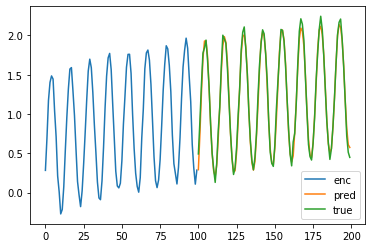

In [70]:
plt.plot(np.arange(enc_len), valid_xy.values[:, :enc_len].reshape(-1), label='enc')
plt.plot(np.arange(enc_len, enc_len+dec_len), pred.reshape(-1).cpu().numpy(), label='pred')
plt.plot(np.arange(enc_len, enc_len+dec_len), valid_xy.values[:, enc_len: enc_len+dec_len].reshape(-1), label='true')
plt.legend()

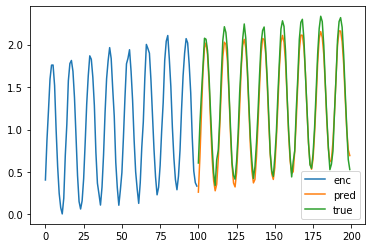

In [71]:
learner.load(epoch=636)
learner.model.eval()
pred = learner.model.predict(enc_x=torch.as_tensor(test_xy.values[:, :enc_len]).float().cuda(), dec_len=dec_len)

plt.plot(np.arange(enc_len), test_xy.values[:, :enc_len].reshape(-1), label='enc')
plt.plot(np.arange(enc_len, enc_len+dec_len), pred.reshape(-1).cpu().numpy(), label='pred')
plt.plot(np.arange(enc_len, enc_len+dec_len), test_xy.values[:, enc_len: enc_len+dec_len].reshape(-1), label='true')
plt.legend()